# Energy Use in Liverpool City Region
This notebook uses some Python tools to display gas and electricity use in liverpool city region.


In [1]:
import pandas as pd ##Pandas to manipulate data
import geopandas as gpd ##GeoPandas to manipulate GeoSpacial data
import folium ##Folium to create interactive maps
import numpy as np ##For a number of useful mathematical functions 
import requests as rq
from shapely.geometry import box, polygon ##Use this to create the grid covering LCR
from branca.colormap import linear ##To create colour scales
from branca import colormap

We are using the follow sources of data
1. Lower and Middle Super Output Areas electricity consumption https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption
    * LSOA Domestic Electricity 2010 to 2022
    * MSOA Non-Domestic Electricity 2010 to 2022
2. Lower and Middle Super Output Areas gas consumption https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption
    * LSOA Domestic Gas 2010 to 2022
    * MSOA Non-Domestic Gas 2010 to 2022

Geospatial data giving the boundaries of all LSOAs and MSOAs are provided by the ONS. We also need to look up which output areas are in Liverpool City Region. 

In [2]:
lsoa_lep_lookup = pd.read_csv('data/Lower_layer_Super_Output_Area_(2021)_to_Local_Enterprise_Partnership_(December_2022)_Lookup_in_England_(V2).csv') #Use this dataset to find out which LSOAs are in LCR, from https://geoportal.statistics.gov.uk/
lsoa_boundaries = gpd.read_file('data/Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_-3320468682147951291.geojson') #Boundaries of all LSOAs in england from https://geoportal.statistics.gov.uk/
lsoa_elc_data = pd.read_excel('data/LSOA_domestic_elec_2010-22.xlsx',sheet_name="2022",skiprows=4) #Domestic electricity use across England https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption
lsoa_gas_data = pd.read_excel("data/LSOA_domestic_gas_2010-2022.xlsx",sheet_name="2022",skiprows=4) #Domestic gas use across England https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption

In [3]:
lsoa_lcr_lookup = lsoa_lep_lookup[lsoa_lep_lookup['LEP22CD1']=='E37000022'] #Returns only those LSOAs which are in Liverpool City Region

In [4]:
lcr_lsoa_boundaries=lsoa_boundaries.merge(lsoa_lcr_lookup,how='inner',on='LSOA21CD')[['LSOA21CD','LSOA21NM_x','BNG_E','BNG_N','LONG','LAT','GlobalID','geometry']] #Returns the boundaries of LSOAs in LCR
lcr_lsoa_boundaries.rename(columns={"LSOA21NM_x":"LSOA21NM"},inplace=True) #Renames columns to more sensible name

In [5]:
lsoa_elc_data.rename(columns={
    "Number\nof meters":"Number of Electric Meters",
    "Total \nconsumption\n(kWh)":"Total Electricity Use",
    "Mean \nconsumption\n(kWh per meter)":"Mean Electricity Use",
    "Median \nconsumption\n(kWh per meter)":"Median Electricity Use"},
                     inplace=True) #Renames columns
lsoa_gas_data.rename(columns={
    "Number\nof meters\n":"Number of Gas Meters",
    "Total \nconsumption\n(kWh)":"Total Gas Use",
    "Mean \nconsumption\n(kWh per meter)":"Mean Gas Use",
    "Median \nconsumption\n(kWh per meter)":"Median Gas Use",
    "Number of\nnon-consuming meters":"Unused Gas Meters"},
                     inplace=True) #Renames columns
lcr_lsoa_elc_data = pd.merge(lsoa_elc_data,lcr_lsoa_boundaries[['LSOA21CD']],left_on="LSOA code",right_on="LSOA21CD",how='inner') #Returns electricity per LSOA for LCR only
lcr_lsoa_elc_data.drop("LSOA21CD",axis="columns",inplace=True) #Drops duplicate columns 
lcr_lsoa_gas_data = pd.merge(lsoa_gas_data,lcr_lsoa_boundaries[['LSOA21CD']],left_on="LSOA code",right_on="LSOA21CD",how='inner')
lcr_lsoa_gas_data.drop("LSOA21CD",axis="columns",inplace=True) #Drops duplicate columns
lcr_lsoa_energy_data=pd.merge(lcr_lsoa_elc_data,lcr_lsoa_gas_data[["LSOA code","Number of Gas Meters","Total Gas Use","Mean Gas Use","Unused Gas Meters"]],on="LSOA code",how="inner") #Creates one file with both electric and gas data

In [6]:
##Define a function which takes a GeoDataFrame and returns an nxm grid of sqaures covering the entire area. 
def grid(geo_data,n):
    bounds=geo_data.total_bounds
    cell_size=(bounds[2]-bounds[0])/n
    grid_cells=[]
    for x0 in np.arange(bounds[0],bounds[2],cell_size):
        for y0 in np.arange(bounds[1],bounds[3],cell_size):
            grid_cells.append(box(x0,y0,x0+cell_size,y0+cell_size))
    return gpd.GeoDataFrame(grid_cells,columns=['geometry'],crs=geo_data.crs)

We might be interested in mapping the energy use by LSOA onto different geographies. Below is an exmaple of how to do this. First we generate a grid covering LCR and then assign energy usage to each grid tile based on the energy use in intersecting LSOAs. Each LSOA which intersects contributes energy usage in proportion to the area of the LSOA which intersects the grid tile. 

Let $L$ be the set of LSOAs, $S$ the set of squares in the grid. For $l\in L$ let $l_a$ be the total area of $l$, $l_e$ the total energy use assigned to $l$ and let $l_s$ be the area of $l$ which overlaps with some sqaure $s \in S$. Then the total energy use for each sqaure $s_e$ is calculated as follows: 
$$s_e = \sum_{l\in L}{(l_s/l_a) \times l_e} $$

In [7]:
lcr_grid=grid(lcr_lsoa_boundaries,50) #Create a grid covering LCR 
#Calculate the total energy use in each grid. This is done by finding what proportion of each LSOA is in each grid sqaure and then assigning that proportion of energy use in that LSOA to that grid sqaure. 
drop_rows = [] #Use this to keep track of which cells are empty, so we can remove them. 
for i in lcr_grid.index: #Iterate over each grid tile
    intersect = gpd.overlay(lcr_grid.iloc[[i]],lcr_lsoa_boundaries) #This creates a GeoDataFrame with a polygon for each LSOA which intersects the grid tile, clipped to the boundaries of the tile. 
    if intersect.empty: #Check if no intersecting LSOAs 
        drop_rows.append(i) #If so remember this so we can remove it at the end. 
    else: #Otherwise go on to calculate the energy use. 
        elc_use=0 
        gas_use=0 
        for j in intersect.index: #Look at each LSOA which intersects the tile
            lsoa=intersect.loc[j]["LSOA21CD"] #Find the code of the LSOA
            intersect_area=intersect.loc[[j]]["geometry"].area #Find the area of the LSOA which intersects the tile
            lsoa_area=lcr_lsoa_boundaries[lcr_lsoa_boundaries["LSOA21CD"]==lsoa].area #Find the total area of the LSOA
            proportion=intersect_area.iloc[0]/lsoa_area.iloc[0] #The proportion of the LSOA within the tile
            lsoa_elc_use=lcr_lsoa_elc_data[lcr_lsoa_elc_data["LSOA code"]==lsoa]["Total Electricity Use"].iloc[0] #The total elctricity use in the LSOA
            lsoa_gas_use=lcr_lsoa_gas_data[lcr_lsoa_gas_data["LSOA code"]==lsoa]["Total Gas Use"].iloc[0] #Total gas use in the LSOA
            elc_use=elc_use + lsoa_elc_use*proportion #Add the relevant proportion of electricity to our overall total for the tile. 
            gas_use=gas_use + lsoa_gas_use*proportion #same for gas. 
        lcr_grid.at[i,"total electricity use"]=elc_use #Assgin the calculated electric use to the grid tile
        lcr_grid.at[i,"total gas use"]=gas_use #Assign the calculate dgas use to the grid tile
lcr_grid.drop(drop_rows,inplace=True) #Drop empty cells 
lcr_grid.reset_index(inplace=True) #Take the index and create a new column with the same values, i need this properly assign the right numbers to the right tiles in the map, proabably so way around this. 

In [8]:
#Creates a folium map with 4 layers: LSOA electric and gas use and Electric and Gas density maps based on the grid above. 
map = folium.Map(location=[53.41409787567685, -2.9965689152099486]) #Create the map, centred on liverpool. 

#Here we add a layer
folium.Choropleth(                                      #Creates a Choropleth data visualisation
    geo_data=lcr_lsoa_boundaries,                       #The underlying geographies we want to colour are the LSOA boundaries
    data=lcr_lsoa_elc_data,                             #The data we want to visualise  
    name="Total electricity Use by LSOA (kWh)",         #The name of the layer
    columns=["LSOA code", "Total Electricity Use"],     #The column we want to visualise is "total electricty use" and the "LSOA code" tells us which shape on the map to assign it to   
    key_on="feature.properties.LSOA21CD",               #The shapes on the map we want to assign the colors to. 
).add_to(map)

folium.Choropleth(
    geo_data=lcr_lsoa_boundaries,
    data=lcr_lsoa_gas_data,
    name="Total gas use by LSOA (kWh)",
    fill_color="OrRd",                                  #Show gas in red instead of blue. 
    columns=["LSOA code", "Total Gas Use"],
    key_on="feature.properties.LSOA21CD",
).add_to(map)
folium.Choropleth(
    geo_data=lcr_grid,
    data=lcr_grid,
    name="Electricity Density",                   #Show grid tiles which don't interesect with any LSOAs as grey. 
    columns=["index", "total electricity use"],
    key_on="feature.properties.index",
).add_to(map)
folium.Choropleth(
    geo_data=lcr_grid,
    data=lcr_grid,
    name="Gas Density",
    fill_color="OrRd",
    columns=["index", "total gas use"],
    key_on="feature.properties.index",
).add_to(map)
folium.LayerControl().add_to(map) #Adds layer control

In [9]:
map.save("EnergyUseMap.html")

<Axes: >

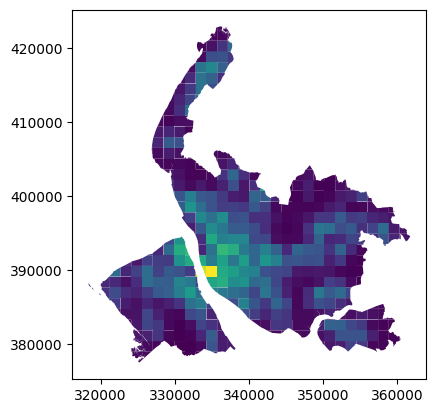

In [10]:
test_grid=grid(lcr_lsoa_boundaries,30) #Create a grid covering LCR 
#Calculate the total energy use in each grid. This is done by finding what proportion of each LSOA is in each grid sqaure and then assigning that proportion of energy use in that LSOA to that grid sqaure. 
drop_rows = [] #Use this to keep track of which cells are empty, so we can remove them. 
for i in test_grid.index: #Iterate over each grid tile
    intersect = gpd.overlay(test_grid.iloc[[i]],lcr_lsoa_boundaries)
    if intersect.empty: #Check if no intersecting LSOAs 
        drop_rows.append(i) #If so remember this so we can remove it at the end. 
    else: #Otherwise go on to calculate the energy use.
        land_area = test_grid.area[i]/intersect.dissolve().area[0]
        elc_use=0 
        gas_use=0 
        for j in intersect.index: #Look at each LSOA which intersects the tile
            lsoa=intersect.loc[j]["LSOA21CD"] #Find the code of the LSOA
            intersect_area=intersect.loc[[j]]["geometry"].area #Find the area of the LSOA which intersects the tile
            lsoa_area=lcr_lsoa_boundaries[lcr_lsoa_boundaries["LSOA21CD"]==lsoa].area #Find the total area of the LSOA
            proportion=intersect_area.iloc[0]/lsoa_area.iloc[0] #The proportion of the LSOA within the tile
            lsoa_elc_use=lcr_lsoa_elc_data[lcr_lsoa_elc_data["LSOA code"]==lsoa]["Total Electricity Use"].iloc[0] #The total elctricity use in the LSOA
            lsoa_gas_use=lcr_lsoa_gas_data[lcr_lsoa_gas_data["LSOA code"]==lsoa]["Total Gas Use"].iloc[0] #Total gas use in the LSOA
            elc_use=elc_use + lsoa_elc_use*proportion #Add the relevant proportion of electricity to our overall total for the tile. 
            gas_use=gas_use + lsoa_gas_use*proportion #same for gas. 
        gas_use=gas_use*land_area
        elc_use=elc_use*land_area
        test_grid.at[i,"total electricity use"]=elc_use #Assgin the calculated electric use to the grid tile
        test_grid.at[i,"total gas use"]=gas_use #Assign the calculate dgas use to the grid tile
        test_grid.at[i,"geometry"]=intersect.dissolve().at[0,"geometry"] #replaces the grid tile with one cut to the shape of the city region
test_grid.drop(drop_rows,inplace=True) #Drop empty cells 
test_grid.reset_index(inplace=True) #Take the index and create a new column with the same values, i need this properly assign the right numbers to the right tiles in the map, proabably so way around this.
test_grid.plot(column="total electricity use")

In [15]:
test_grid['Elc GWh'] = test_grid['total electricity use'].apply(lambda x:round(x/1000))
test_grid['Gas GWh'] = test_grid['total gas use'].apply(lambda x:round(x/1000))
elc_colors = colormap.LinearColormap(["#ffffff","#0000ff"],vmin=test_grid['Elc GWh'].min(),vmax=test_grid['Elc GWh'].max(),caption="Electricty Density (GWh)")
gas_colors = colormap.LinearColormap(["#ffffff","#ff0000"],vmin=test_grid['Gas GWh'].min(),vmax=test_grid['Gas GWh'].max(),caption="Gas Density (GWh)")

In [16]:
test_map = folium.Map(location=[53.41409787567685, -2.9965689152099486])
folium.GeoJson(
    test_grid,
    name="Elc GWh",
    popup=folium.GeoJsonPopup(fields=["Elc GWh"]),
    style_function=lambda feature: {
        "fillColor": elc_colors(feature['properties']['Elc GWh']),
        "color": "black",
        "weight": 0,
        "fillOpacity": 0.5,
    },
).add_to(test_map)
folium.GeoJson(
    test_grid,
    name="Gas GWh",
    popup=folium.GeoJsonPopup(fields=["Gas GWh"]),
    style_function=lambda feature: {
        "fillColor": gas_colors(feature['properties']['Gas GWh']),
        "color": "black",
        "weight": 0,
        "fillOpacity": 0.5,
    },
).add_to(test_map)
folium.LayerControl().add_to(test_map)

In [17]:
test_map

In [ ]:
elc_colors = colormap.LinearColormap(["#ffffff","#0000ff"],vmin=test_grid['total electricity use'].min(),vmax=test_grid['total electricity use'].max(),caption="Electricty Density")

In [ ]:
gas_colors = colormap.LinearColormap(["#ffffff","#ff0000"],vmin=test_grid['total electricity use'].min(),vmax=test_grid['total electricity use'].max(),caption="Gas Density")

In [ ]:
elc_colors